In [1]:
!pip install langchain-groq
!pip install --upgrade -U langchain-core langchain-groq langchain_groq langchain

In [2]:
from langchain_groq import ChatGroq

from dotenv import load_dotenv
import os
load_dotenv()
groq_api_key = os.getenv("groq_api_key")
llm = ChatGroq(model_name="llama-3.1-8b-instant", api_key=groq_api_key)

Importing all the Libraries

In [3]:
from pydantic import BaseModel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
from langgraph.graph import StateGraph, START, END

Defining the State Object

In [4]:
class State(BaseModel):
    input: str
    route: str | None = None
    output: str | None = None

Defining the State Graph

In [5]:
graph = StateGraph(State)

In [6]:
from langchain_core.output_parsers import StrOutputParser

system_prompt = """
You are a helpful assistant that can answer questions about Mental Health.
"""

user_question = "What are some effective strategies for managing anxiety and stress in daily life?"

human_prompt = f"""
{user_question}
"""

from langchain_core.prompts import ChatPromptTemplate , SystemMessagePromptTemplate , HumanMessagePromptTemplate

system_message_prompt = SystemMessagePromptTemplate.from_template(system_prompt)

human_message_prompt = HumanMessagePromptTemplate.from_template(human_prompt)

prompt = ChatPromptTemplate.from_messages([system_message_prompt , human_message_prompt])

chain = prompt | llm | StrOutputParser()

chain.invoke({"user_question":user_question})

"Managing anxiety and stress is crucial for maintaining overall well-being. Here are some effective strategies for managing anxiety and stress in daily life:\n\n1. **Mindfulness and Meditation**: Practice mindfulness meditation, deep breathing exercises, or yoga to calm your mind and body. Regular mindfulness practice can help reduce anxiety and stress levels.\n\n2. **Exercise and Physical Activity**: Engage in regular physical activity, such as walking, running, swimming, or any other exercise that you enjoy. Exercise releases endorphins, which can help reduce anxiety and stress.\n\n3. **Time Management**: Prioritize tasks, set realistic goals, and take regular breaks to avoid feeling overwhelmed. Use a planner, calendar, or app to stay organized and manage your time effectively.\n\n4. **Grounding Techniques**: Practice grounding techniques, such as focusing on your five senses (sight, sound, touch, taste, and smell), to bring yourself back to the present moment and reduce anxiety.\n\

In [7]:
def router_agent(state: State) -> State:
    system_prompt = (
        "You are a routing assistant for a campus mental health system. Based on the user's input, determine which agent should handle it. "
        "Classify the input and respond with one of the following: 'RAG', 'RISK', 'SUPPORT', 'RESOURCE', or 'PEER'. "
        "- 'RAG': For informational queries about mental health or remedies (e.g., 'What is depression?', 'Remedies for anxiety'). "
        "- 'RISK': For inputs indicating distress, crisis, or mental health concerns (e.g., 'I'm stressed', 'feeling anxious'). "
        "- 'SUPPORT': For inputs requesting immediate help or conversation (e.g., 'I need someone to talk to'). "
        "- 'RESOURCE': For inputs asking about campus resources, counselors, or helplines (e.g., 'Where can I get counseling?'). "
        "- 'PEER': For inputs seeking peer support or community (e.g., 'I want to connect with others')."
    )

    user_prompt = state.input

    # Create chat prompt
    system_template = SystemMessagePromptTemplate.from_template("{system_prompt}")
    user_template = HumanMessagePromptTemplate.from_template("{user_prompt}")
    final_template = ChatPromptTemplate.from_messages([system_template, user_template])

    # Call LLM
    chain = final_template | llm | StrOutputParser()
    result = chain.invoke({"system_prompt": system_prompt, "user_prompt": user_prompt})

    # Map LLM output to agent routes
    route_map = {
        "RAG": "rag_knowledge_agent",
        "RISK": "risk_assessment_agent",
        "SUPPORT": "support_chat_agent",
        "RESOURCE": "resource_coordinator_agent",
        "PEER": "peer_connector_agent"
    }
    route = route_map.get(result.upper(), "support_chat_agent")  # Default to support_chat_agent
    return State(input=state.input, route=route, output=None)

In [8]:
def rag_knowledge_agent(state: State) -> State:
    system_prompt = (
        "You are a knowledge agent for mental health information. Use the provided context from PDFs and scraped websites "
        "to answer the user's query about mental health, remedies, or related topics. Provide clear, accurate, and concise "
        "information. If the query is unclear, ask for clarification."
    )
    user_prompt = state.input
    # Run RAG chain
    result = rag_chain.invoke({"query": user_prompt})
    output = result["result"]
    return State(input=state.input, route=state.route, output=output)

In [9]:
def risk_assessment_agent(state: State) -> State:
    system_prompt = (
        "You are a mental health risk assessment agent. Analyze the user's input for signs of distress, stress, or crisis. "
        "Provide a concise assessment (e.g., 'High risk: Immediate support recommended') and suggest next steps. "
        "Ensure responses are empathetic and avoid clinical diagnoses."
    )
    user_prompt = state.input
    final_template = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template("{system_prompt}"),
        HumanMessagePromptTemplate.from_template("{user_prompt}")
    ])
    chain = final_template | llm | StrOutputParser()
    result = chain.invoke({"system_prompt": system_prompt, "user_prompt": user_prompt})
    return State(input=state.input, route=state.route, output=result)

In [10]:
def support_chat_agent(state: State) -> State:
    system_prompt = (
        "You are a supportive chatbot for students seeking mental health help. Provide empathetic, conversational responses "
        "to offer immediate emotional support. Encourage the user and suggest reaching out to campus resources if needed. "
        "Keep responses warm, non-judgmental, and confidential."
    )
    user_prompt = state.input
    final_template = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template("{system_prompt}"),
        HumanMessagePromptTemplate.from_template("{user_prompt}")
    ])
    chain = final_template | llm | StrOutputParser()
    result = chain.invoke({"system_prompt": system_prompt, "user_prompt": user_prompt})
    return State(input=state.input, route=state.route, output=result)

In [11]:
def resource_coordinator_agent(state: State) -> State:
    system_prompt = (
        "You are a resource coordinator for campus mental health services. Based on the user's input, recommend specific "
        "campus resources (e.g., counseling center, helplines, workshops) with clear contact details or next steps. "
        "If no specific resources are known, suggest general options like 'Visit your campus counseling center'."
    )
    user_prompt = state.input
    final_template = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template("{system_prompt}"),
        HumanMessagePromptTemplate.from_template("{user_prompt}")
    ])
    chain = final_template | llm | StrOutputParser()
    result = chain.invoke({"system_prompt": system_prompt, "user_prompt": user_prompt})
    return State(input=state.input, route=state.route, output=result)

In [12]:
def peer_connector_agent(state: State) -> State:
    system_prompt = (
        "You are a peer connector agent. Based on the user's input, suggest ways to connect with peer support groups or "
        "individuals with similar experiences (e.g., student clubs, online forums). Provide actionable steps to join or "
        "engage with these communities, ensuring inclusivity and sensitivity."
    )
    user_prompt = state.input
    final_template = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template("{system_prompt}"),
        HumanMessagePromptTemplate.from_template("{user_prompt}")
    ])
    chain = final_template | llm | StrOutputParser()
    result = chain.invoke({"system_prompt": system_prompt, "user_prompt": user_prompt})
    return State(input=state.input, route=state.route, output=result)

In [13]:
def route_next(state: State):
    return state.route  # Must return the node name as string

In [14]:
# Initialize the graph
graph = StateGraph(State)

# Add nodes for each agent
graph.add_node("router_agent", router_agent)
graph.add_node("rag_knowledge_agent", rag_knowledge_agent)
graph.add_node("risk_assessment_agent", risk_assessment_agent)
graph.add_node("support_chat_agent", support_chat_agent)
graph.add_node("resource_coordinator_agent", resource_coordinator_agent)
graph.add_node("peer_connector_agent", peer_connector_agent)

# Add conditional edges from router_agent
graph.add_conditional_edges(
    "router_agent",
    route_next,
    {
        "rag_knowledge_agent": "rag_knowledge_agent",
        "risk_assessment_agent": "risk_assessment_agent",
        "support_chat_agent": "support_chat_agent",
        "resource_coordinator_agent": "resource_coordinator_agent",
        "peer_connector_agent": "peer_connector_agent"
    }
)

# Add end edges for each agent
graph.add_edge("rag_knowledge_agent", END)
graph.add_edge("risk_assessment_agent", END)
graph.add_edge("support_chat_agent", END)
graph.add_edge("resource_coordinator_agent", END)
graph.add_edge("peer_connector_agent", END)

# Set entry point
graph.set_entry_point("router_agent")

# Compile the graph
multi_agent_graph = graph.compile()

In [15]:
multi_agent_graph = graph.compile()

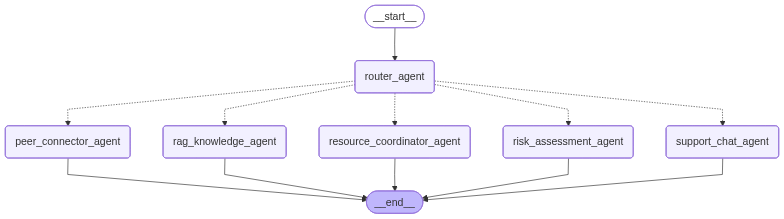

In [16]:
multi_agent_graph

In [19]:
def chat(user_input: str) -> State:
    initial_state = State(input=user_input)
    result = multi_agent_graph.invoke(initial_state)
    return result

In [21]:
# Test with different inputs
test_inputs = [
    "What are some remedies for anxiety?",
    "I'm feeling really stressed and overwhelmed with exams.",
    "I need someone to talk to right now.",
    "Where can I find a counselor on campus?",
    "I want to join a group to meet people going through similar stuff."
]

for input_text in test_inputs:
    response_state = chat(input_text)
    print(response_state)

{'input': 'What are some remedies for anxiety?', 'route': 'support_chat_agent', 'output': 'You\'re looking for some remedies to help manage anxiety. That takes a lot of courage to acknowledge and seek out. I\'m here to support you.\n\nFirstly, let\'s talk about some self-care practices that can really help:\n\n1. **Deep breathing exercises**: When we\'re anxious, our breathing tends to get shallow and rapid. Consciously taking slow, deep breaths can calm the nervous system.\n2. **Physical activity**: Regular exercise, even just a short walk, can help reduce anxiety by releasing endorphins, also known as "feel-good" hormones.\n3. **Mindfulness**: Focus on the present moment, without judgment. You can try meditation, yoga, or guided imagery to help calm your mind.\n4. **Grounding techniques**: Use your senses to ground yourself in the present moment. For example, notice the sensation of your feet on the ground, the sounds around you, or the sensation of the air on your skin.\n5. **Journa